## Settings

In [1]:
import sys
sys.path.insert(0, '..')

import Functions as fxns

from Functions import pd
pd.set_option('display.max_columns', None)

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

from joblib import dump, load

from datetime import date

import plotly.express as px

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

import seaborn as sns

from imblearn import over_sampling

## Import & Pre-Processing

In [2]:
# fxns.merge_dfs()

In [3]:
df = pd.read_csv('../data/kkbox_merged.csv', index_col='msno')

In [4]:
# convert missing/junk ages to 0 for imputation later
df.loc[df.bd <= 0, 'bd'] = np.nan
df.loc[df.bd > 100, 'bd'] = np.nan

In [5]:
# numerically encode gender
df.loc[df.gender == 'female', 'gender'] = 1
df.loc[df.gender == 'male', 'gender'] = 0

# convert dtype from object to float for imputer
df.gender = df.gender.astype(float)

In [6]:
df = df.rename(columns={'gender': 'is_female',
                        'date': 'listen_date'})

### Imputation

In [7]:
# columns with missing values
print('Columns with missing values:\n', df.isna().any()[df.isna().any()])

print('\nPercent missingness in bd column:\n',
    (len(df.bd) - df.bd.value_counts().sum())
     / len(df.bd) * 100)

print('\nPercent missingness in gender column:\n',
    (len(df.is_female) - df.is_female.value_counts().sum())
     / len(df.is_female) * 100)

Columns with missing values:
 bd           True
is_female    True
dtype: bool

Percent missingness in bd column:
 46.227529937758035

Percent missingness in gender column:
 46.23288792577401


In [8]:
# group df by user for imputing user age and gender
df_by_msno = df.groupby('msno').mean()

# KNN is distance-based so data must be temporarily scaled
scaler = MinMaxScaler()
scaler_fitted = scaler.fit(df_by_msno)
scaled_df = pd.DataFrame(scaler_fitted.transform(df_by_msno),
                         index=df_by_msno.index, columns=df_by_msno.columns)

In [9]:
# # impute scaled user-grouped df
# imputer = KNNImputer(n_neighbors=round(np.sqrt(len(df))))
# imputed_array = imputer.fit_transform(scaled_df)
# dump(imputed_array, '../data/imputed_array.pkl')

# undo scaling
imputed_array = load('../data/imputed_array.pkl')
inverse_array = scaler_fitted.inverse_transform(imputed_array)
imputed_df = \
    pd.DataFrame(inverse_array,
                 index=df_by_msno.index, columns=df_by_msno.columns)

In [10]:
# classify predictions as female or male using 50% threshold
imputed_df.loc[imputed_df.is_female >= 0.5, 'is_female'] = 1
imputed_df.loc[imputed_df.is_female < 0.5, 'is_female'] = 0

In [11]:
# convert bd from float to int
imputed_df.bd = imputed_df.bd.apply(lambda x: round(x))

In [12]:
# merge imputed columns
df = df.drop(['bd', 'is_female'], axis=1
       ).merge(imputed_df[['bd', 'is_female']],
         how='left', left_index=True, right_index=True)

df = df[['is_churn', 'city', 'bd', 'is_female', 'registered_via',
         'registration_init_time', 'payment_method_id',
         'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
         'is_auto_renew', 'transaction_date', 'membership_expire_date',
         'is_cancel', 'listen_date', 'num_25', 'num_50', 'num_75',
         'num_985', 'num_100', 'num_unq', 'total_secs']]

In [13]:
# change numeric cols that represent categorical data to object dtype
for col in ['city', 'registered_via', 'payment_method_id']:
    df[col] = df[col].astype(str)

In [14]:
# change date cols to datetime dtype
date_cols = ['registration_init_time', 'transaction_date',
             'membership_expire_date', 'listen_date']

df[date_cols] = \
    df[date_cols].apply(lambda x: pd.to_datetime(x, format='%Y%m%d'))

## EDA

### Correlation

In [65]:
px.imshow(df.corr(), x=df.corr().columns, y=df.corr().index)

In [ ]:
# Strong correlations between:
#     plan days, list price and amount paid
#     num_100, num_unq, total_secs

# Midrange correlations between:
#     churn and plan days/list price/amount paid
#     auto_renew and plan days/list price/amount paid (negative)
#     churn and auto_renew (negative)
#     bd and auto_renew
#     num_unq and num_25

# Some correlation between:
#     churn and cancellation

### Relationships with Churn

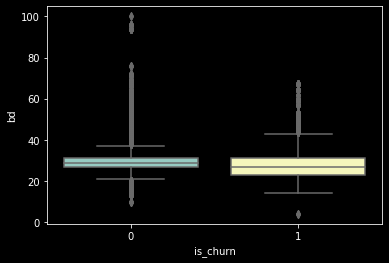

In [16]:
sns.boxplot('is_churn', 'bd', data=df);
# The age range of customers who churn tends to be slightly younger

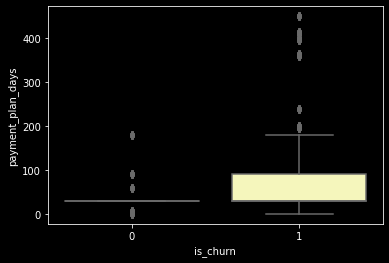

In [17]:
sns.boxplot('is_churn', 'payment_plan_days', data=df);
# Customers tend to churn after being members longer,
# perhaps they get bored of what the service tends to offer
# or they forgot to renew after not needing to for a long time
# or their credit card may expire

# is usage similar between people who have longer plans 
# and shorter plans as it relates to churn?

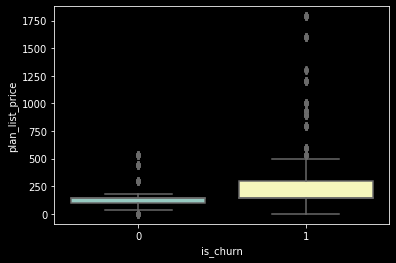

In [18]:
sns.boxplot('is_churn', 'plan_list_price', data=df);
# customers who have a more expensive plan more tend to churn more

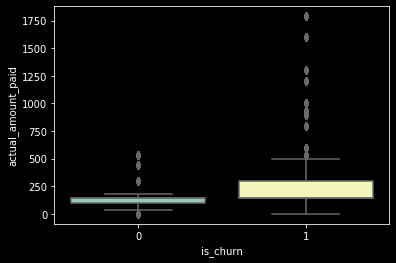

In [19]:
sns.boxplot('is_churn', 'actual_amount_paid', data=df);
# customers who pay more tend to churn more

In [20]:
# No clear patterns between churn and songs played
# No clear patterns between churn and unique songs
# No clear patterns between churn and total secs

### Categorical Variables

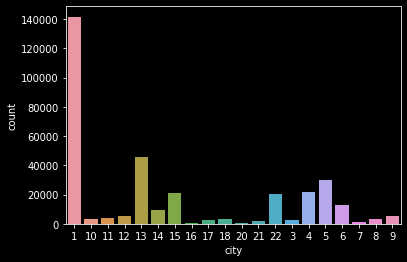

In [21]:
sns.countplot('city', data=df);

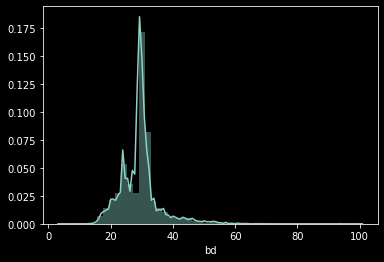

In [22]:
sns.distplot(df.bd);

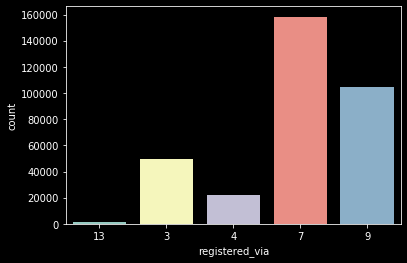

In [23]:
sns.countplot('registered_via', data=df);

### Time Series

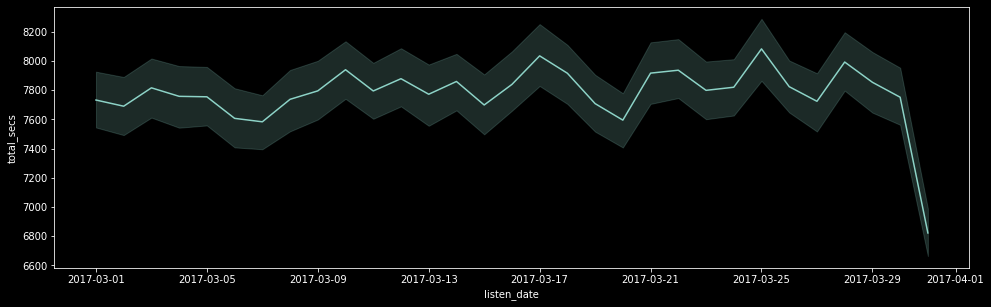

In [38]:
means_by_listen_date = df.groupby(['msno', 'listen_date']).mean().reset_index()

plt.figure(figsize=(16.4, 4.8))
sns.lineplot('listen_date', 'total_secs', data=means_by_listen_date);

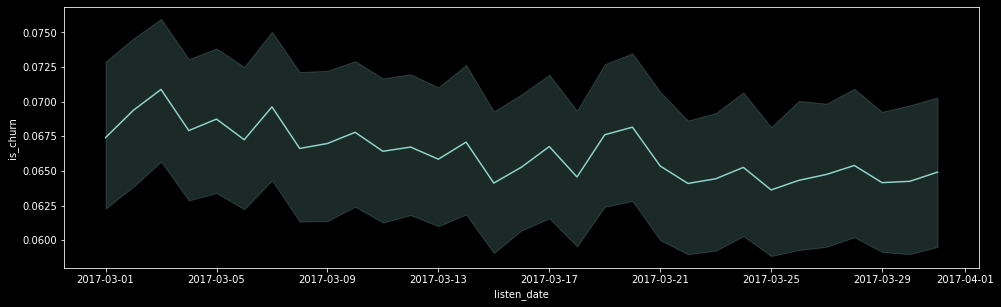

In [39]:
plt.figure(figsize=(16.4, 4.8))
sns.lineplot('listen_date', 'is_churn', data=means_by_listen_date);
# churn declines a percent or so throughout the month

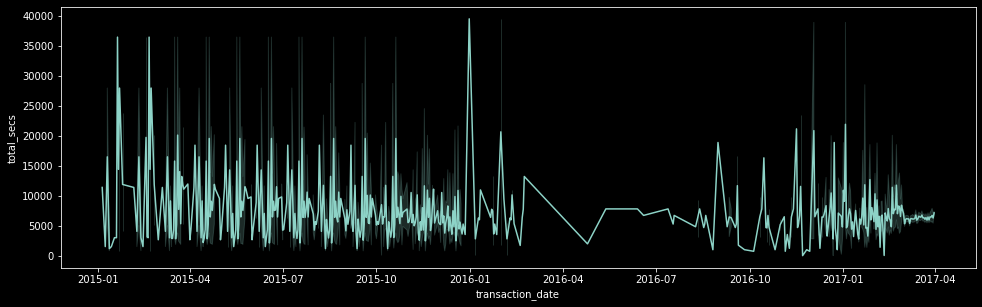

In [42]:
means_by_trans_date = df.groupby(['msno', 'transaction_date']).mean().reset_index()

plt.figure(figsize=(16.4, 4.8))
sns.lineplot('transaction_date', 'total_secs', data=means_by_trans_date);

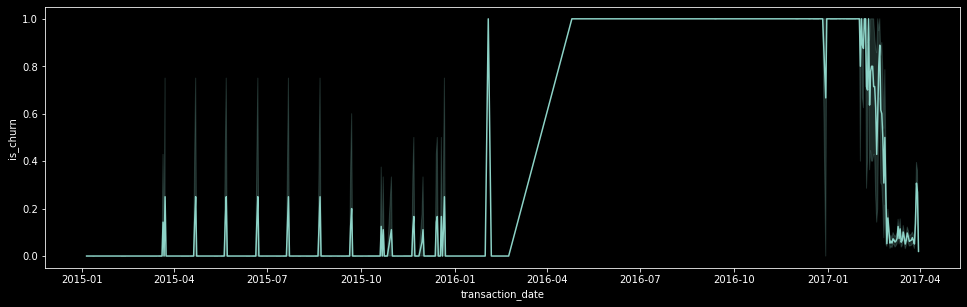

In [43]:
plt.figure(figsize=(16.4, 4.8))
sns.lineplot('transaction_date', 'is_churn', data=means_by_trans_date);

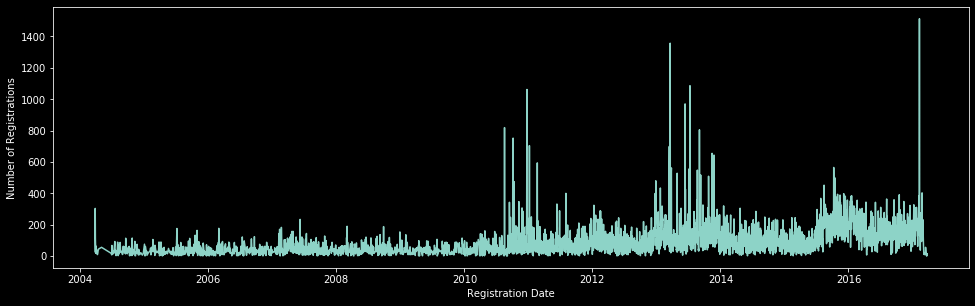

In [61]:
plt.figure(figsize=(16.4, 4.8))
sns.lineplot('registration_init_time', 'registered_via',
             data=df.groupby('registration_init_time').count().reset_index()
            ).set(xlabel='Registration Date', ylabel='Number of Registrations');

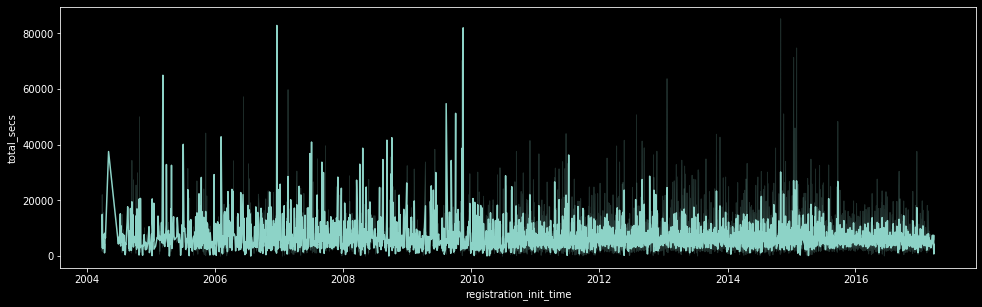

In [64]:
means_by_reg_date = df.groupby(['msno', 'registration_init_time']).mean().reset_index()

plt.figure(figsize=(16.4, 4.8))
sns.lineplot('registration_init_time', 'total_secs', data=means_by_reg_date);

In [25]:
df.columns

Index(['is_churn', 'city', 'bd', 'is_female', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel',
       'listen_date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
       'num_unq', 'total_secs'],
      dtype='object')

### Feature Engineering

## Modeling

### Pre-processing

In [26]:
# imbalanced classes
print('Churn percent:', df.is_churn.sum() / len(df) * 100)

Churn percent: 8.97820191875504
